In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    ImageIO,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260


# Kernel dimensions

In [17]:
batch = 3000


# files = readdir(datadir("img"))
files = ["kan_sq_cont_l.png"]


tspan = (0.0f0, 100f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("bench_kern", batch_)))

para_sets = [
    (
        H_fact = 13.0f0,
        T_fact = [0.87f0, 0.13f0],
        T_p_m = 0.302f0,
        W_p_same_fact = 39f0,
        W_m_same_fact = 330f0,
        H_l = 19,
        W_l = 19,
    ),
    (
        H_fact = 13.0f0,
        T_fact = [0.87f0, 0.13f0],
        T_p_m = 0.302f0,
        W_p_same_fact = 39f0,
        W_m_same_fact = 330f0,
        H_l = 15,
        W_l = 19,
    ),
    (
        H_fact = 13.0f0,
        T_fact = [0.87f0, 0.13f0],
        T_p_m = 0.302f0,
        W_p_same_fact = 39f0,
        W_m_same_fact = 330f0,
        H_l = 19,
        W_l = 15,
    ),
    (
        H_fact = 13.0f0,
        T_fact = [0.87f0, 0.13f0],
        T_p_m = 0.302f0,
        W_p_same_fact = 39f0,
        W_m_same_fact = 330f0,
        H_l = 15,
        W_l = 15,
    ),
]
test_name = ["base", "H_l15", "W_l15", "H_l15W_l15"]
test_name_plt =
    ["\$W: 19,\\quad H: 19\$", 
    "\$W: 19,\\quad H: 15\$",
    "\$W: 15,\\quad H: 19\$",
    "\$W: 15,\\quad H: 15\$"]

benchm_ke = []

file = files[1]

for para_test ∈ enumerate(para_sets)
    # try
        global p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("img", file),
            Parameters.para_var_k(para_test[2]),
        )

        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(@view u0[:, :, 1:2, :])
        arr2 = similar(@view u0[:, :, 1:1, :])

        global f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )
        global prob_ke = ODEProblem(f, u0, tspan, p)
#         push!(benchm_ke, @benchmark solve(prob_ke))
        global du = similar(u0)
    global u_ = u0
        push!(benchm_ke, @benchmark f(du, u_, p, 1.0f0))
#         sol = solve(prob_ke)

end

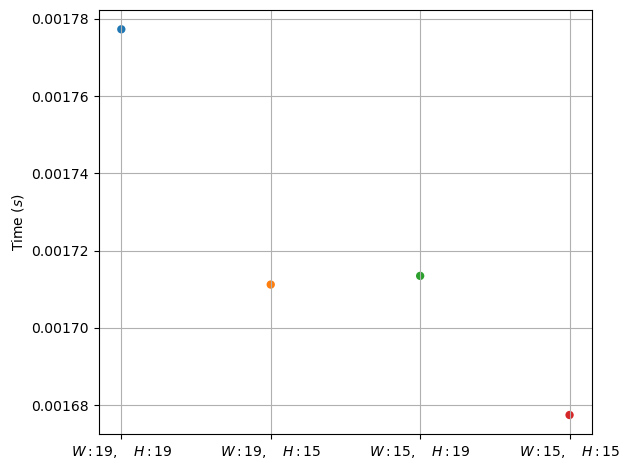

In [30]:
# benchmark plot
fig, ax = plt.subplots()


for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        median(benchm_ke[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end
# ax.legend()
ax.grid(true)
# ax.set_ylabel("Memory (\$MB\$)")
# ax.set_ylim(ymin=0)
ax.set_ylabel("Time (\$s\$)")
# ax.set_xlim(xmin=0)
fig.tight_layout()
# ax.title("Size of W and H kernels")
plt.savefig(plotsdir(
    string("bench_kern", batch_),
    string(file, "_bench_kern_dim.png"),
))
# close("all")

# Implementations

In [ ]:
benchm_i = []
tspan = (0.0f0, 10f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("bench_imp", batch_)))
file = "kan_sq_cont_l.png"

test_name_plt = [
    "GPU conv",
    "CPU conv",
    "CPU imfilter",
    "GPU imfilter FFT",
    "GPU imfilter IIR",
    "GPU imfilter FIR",
]

# GPU
p = LaminartInitFunc.parameterInit_conv_gpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = cu(reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
))

arr1 = similar(@view u0[:, :, 1:p.K, :])
arr2 = similar(@view u0[:, :, 1:1, :])

f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
prob_i = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob_i))



# CPU conv

p = LaminartInitFunc.parameterInit_conv_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
)

arr1 = similar(@view u0[:, :, 1:p.K, :])
arr2 = similar(@view u0[:, :, 1:1, :])

f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
prob_i = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob_i))


# CPU imfilter

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_cpu(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

prob = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob))



# GPU imfilter FFT

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_gpu_fft(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

prob = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob))



# GPU imfilter IIR

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_gpu_iir(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

prob = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob))



# GPU imfilter FIR

p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_gpu_fir(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

prob = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob))


# benchmark plot

# time
fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        median(benchm_i[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Time (\$s\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_imp", batch_), string("bench_imp_time.png")))
close("all")




# memory

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].memory * 1e-6,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Memory (\$MB\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_imp", batch_), string("bench_imp_mem.png")))
close("all")


# alloc

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].allocs,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Allocations")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_imp", batch_),
    string("bench_imp_alloc.png"),
))
close("all")

# Convolution 

In [38]:
benchm_i = []
tspan = (0.0f0, 10f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("bench_imp", batch_)))
file = "kan_sq_cont_l.png"

test_name_plt = [
    "CPU conv",
    "CPU imfilter",
    "GPU imfilter FFT",
    "GPU imfilter IIR",
    "GPU imfilter FIR",
]



5-element Array{String,1}:
 "CPU conv"
 "CPU imfilter"
 "GPU imfilter FFT"
 "GPU imfilter IIR"
 "GPU imfilter FIR"

In [39]:
# CPU conv

global p = LaminartInitFunc.parameterInit_conv_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
)

arr1 = similar(@view u0[:, :, 1:p.K, :])
arr2 = similar(@view u0[:, :, 1:1, :])

f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
        global prob_ke = ODEProblem(f, u0, tspan, p)
#         push!(benchm_ke, @benchmark solve(prob_ke))
        global du = similar(u0)
    global u_ = u0
        push!(benchm_ke, @benchmark f(du, u_, p, 1.0f0))

6-element Array{Any,1}:
 Trial(1.652 ms)
 Trial(1.663 ms)
 Trial(1.643 ms)
 Trial(1.641 ms)
 Trial(94.021 ms)
 Trial(94.710 ms)

In [79]:
# CPU imfilter

global p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_cpu(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2[:,:,1]), # v_C_temp1,
    similar(arr2[:,:,1]), # v_C_temp2,
    similar(arr1[:,:,1]), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

        global prob_ke = ODEProblem(f, u0, tspan, p)
#         push!(benchm_ke, @benchmark solve(prob_ke))
        global du = similar(u0)
    global u_ = u0
        push!(benchm_ke, @benchmark f(du, u_, p, 1.0f0))

BoundsError: BoundsError: attempt to access 100×100 Array{Float32,2} at index [Base.Slice(Base.OneTo(100)), Base.Slice(Base.OneTo(100)), 2]

In [41]:
# GPU imfilter FFT

global p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_gpu_fft(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

        global prob_ke = ODEProblem(f, u0, tspan, p)
#         push!(benchm_ke, @benchmark solve(prob_ke))
        global du = similar(u0)
    global u_ = u0
        push!(benchm_ke, @benchmark f(du, u_, p, 1.0f0))

BoundsError: BoundsError: attempt to access ()
  at index [1]

In [78]:
# GPU imfilter IIR

global p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_gpu_iir(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

        global prob_ke = ODEProblem(f, u0, tspan, p)
#         push!(benchm_ke, @benchmark solve(prob_ke))
        global du = similar(u0)
    global u_ = u0
        push!(benchm_ke, @benchmark f(du, u_, p, 1.0f0))

MethodError: MethodError: no method matching factorkernel(::Tuple{OffsetArrays.OffsetArray{Float32,2,Array{Float32,2}},OffsetArrays.OffsetArray{Float32,2,Array{Float32,2}}})
Closest candidates are:
  factorkernel(!Matched::AbstractArray{T,2}) where T at /mnt/storage_1/users/cullinanen/.julia/packages/ImageFiltering/LvWYb/src/imfilter.jl:1496
  factorkernel(!Matched::AbstractArray) at /mnt/storage_1/users/cullinanen/.julia/packages/ImageFiltering/LvWYb/src/imfilter.jl:1492
  factorkernel(!Matched::ImageFiltering.Kernel.Laplacian) at /mnt/storage_1/users/cullinanen/.julia/packages/ImageFiltering/LvWYb/src/imfilter.jl:1493

In [77]:
u = u0
# function fun_v_C!(
#     v_C::AbstractArray,
#     v_p::AbstractArray,
#     v_m::AbstractArray,
#     v_C_temp1::AbstractArray,
#     v_C_temp2::AbstractArray,
#     v_C_tempA::AbstractArray,
#     p::NamedTuple,
# )
    #     V = similar(v_p)
    #     temp = similar(v_p)
#  arr2, #x_lgn,
C = arr1 #C,
# v_C_temp2 = similar(arr1), #H_z,
#     similar(arr1), # H_z_temp,
   v_C_temp1 =  similar(arr2) # v_C_temp1,
   v_C_temp2 =  similar(arr2) # v_C_temp2,
   v_C_tempA =  similar(arr1) # v_C_tempA,

        x = @view u[:, :, 1:p.K]
        y = @view u[:, :, p.K+1:2*p.K]
        m = @view u[:, :, 2*p.K+1:3*p.K]
        z = @view u[:, :, 3*p.K+1:4*p.K]
        s = @view u[:, :, 4*p.K+1:5*p.K]

        v_p = @view u[:, :, 5*p.K+1]
        v_m = @view u[:, :, 5*p.K+2]

        dx = @view du[:, :, 1:p.K]
        dy = @view du[:, :, p.K+1:2*p.K]
        dm = @view du[:, :, 2*p.K+1:3*p.K]
        dz = @view du[:, :, 3*p.K+1:4*p.K]
        ds = @view du[:, :, 4*p.K+1:5*p.K]

        dv_p = @view du[:, :, 5*p.K+1]
        dv_m = @view du[:, :, 5*p.K+2]


#         LaminartEqImfilter.fun_x_lgn!(ff.x_lgn, x, p)
#         LaminartEqImfilter.fun_v_C!(
#             C,
#             v_p,
#             v_m,
#             v_C_temp1,
#             v_C_temp2,
#             v_C_tempA,
#             p,
#         )



#     similar(arr1[:,:,1]), #W_temp

    @. v_C_temp2 = exp(-1.0f0 / 8.0f0) * (max(v_p, 0f0) - max(v_m, 0f0))
    imfilter!(v_C_temp1[:,:,1], v_C_temp2[:,:,1], centered(p.k_gauss_2))

#     #     A = similar(v_C)
#     #     allocate B to v_C
#     # @inbounds begin
#     for k ∈ 1:p.K
#         a = @view v_C_tempA[:, :, k]
#         b = @view v_C[:, :, k]
#         imfilter!(a, v_C_temp1, centered(p.k_C_A[:, :, k]), )
#         imfilter!(b, v_C_temp1, centered(p.k_C_B[:, :, k]), )
#     end
#     # end
#     @. v_C =
#         p.γ * (max(v_C_tempA - abs(v_C), 0f0) + max(-v_C_tempA - abs(v_C), 0f0))
#     return nothing
# end


100×100 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [66]:
v_C_temp1
# v_C_temp2, centered(p.k_gauss_2)

100×100×1 Array{Float32,3}:
[:, :, 1] =
  5.78521f-34   6.0f-45       5.78184f-34  …  0.0           0.0
  0.0           0.0           0.0             0.0           1.0f-45
  0.0           0.0           0.0             0.0           0.0
  1.0f-45       0.0           1.0f-45         0.0           0.0
  5.78147f-34   9.1837f-41    5.78196f-34     5.79939f-34   0.0
  0.0           2.335f-42     0.0          …  0.0           0.0
  0.0           0.0           0.0             0.0           0.0
  1.0f-45       3.0f-45       1.0f-45         6.0f-45       0.0
  5.7814f-34    0.0           5.78284f-34     0.0           2.5f-44
  0.0           6.0f-45       0.0             0.0           0.0
  0.0           0.0           0.0          …  0.0          -1.37082f-6
  6.0f-45       0.0           1.0f-45         0.0           4.558f-41
  3.0f-45       0.0          -1.27973f-6      0.0           9.73f-42
  ⋮                                        ⋱               
  5.78534f-34   5.78171f-34   0.0         

In [43]:
# GPU imfilter FIR

global p = LaminartInitFunc.parameterInit_imfil_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2);


arr1 = u0[:, :, 1:p.K]
arr2 = u0[:, :, 1:1];


f = LaminartFunc.LamFunction_imfil_gpu_fir(
 arr2, #x_lgn,
arr1, #C,
similar(arr1), #H_z,
    similar(arr1), # H_z_temp,
    similar(arr2), # v_C_temp1,
    similar(arr2), # v_C_temp2,
    similar(arr1), # v_C_tempA,
    similar(arr1[:,:,1]), #W_temp
    );

        global prob_ke = ODEProblem(f, u0, tspan, p)
#         push!(benchm_ke, @benchmark solve(prob_ke))
        global du = similar(u0)
    global u_ = u0
        push!(benchm_ke, @benchmark f(du, u_, p, 1.0f0))

ArgumentError: ArgumentError: Pad{2}(:replicate, (2, 2), (2, 2)) lacks the proper padding sizes for an array with 3 dimensions

In [44]:
# benchmark plot

# time
fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        median(benchm_i[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Time (\$s\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_imp", batch_), string("bench_imp_time.png")))
close("all")




# memory

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].memory * 1e-6,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Memory (\$MB\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_imp", batch_), string("bench_imp_mem.png")))
close("all")


# alloc

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].allocs,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Allocations")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_imp", batch_),
    string("bench_imp_alloc.png"),
))
close("all")

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

# Solver


In [ ]:

benchm_s = []
benchm_sname = []
alg_ = []
stats_ = []
benchm_sc = []
benchm_snamec = []


tspan = (0.0f0, 800f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("bench_solver", batch_)))
file = "kan_sq_cont_l.png"

solvers = [
    AutoTsit5(Rosenbrock23()),
    Tsit5(),
    lsoda(),
    VCAB4(),
    ImplicitHairerWannerExtrapolation(),
    AutoDP5(Rosenbrock23()),
    AutoVern6(Rosenbrock23()),
]
# alg=lsoda()

# GPU
p = LaminartInitFunc.parameterInit_conv_gpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = cu(reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
))

arr1 = similar(@view u0[:, :, 1:2, :])
arr2 = similar(@view u0[:, :, 1:1, :])
f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
prob_i = ODEProblem(f, u0, tspan, p)


for alg in solvers
    @. u0 = 0.0f0
    try
        sol = solve(prob_s, alg)
        push!(alg_, sol.alg)
        push!(stats_, sol.destats)
        push!(benchm_s, @benchmark solve(prob_s, alg))
    catch err
        print(err)
    end
end




end

# CPU conv

p = LaminartInitFunc.parameterInit_conv_cpu(
    datadir("img", file),
    Parameters.parameters_f32,
);

u0 = reshape(
    zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
    p.dim_i,
    p.dim_j,
    5 * p.K + 2,
    1,
)


f = LaminartFunc.LamFunction(
    arr1, #x
    similar(arr1), #m
    similar(arr1), #s
    arr2, #x_lgn,
    similar(arr1), #C,
    similar(arr1), #H_z,
    similar(arr1), # dy_temp,
    similar(arr1), # dm_temp,
    similar(arr1), # dz_temp,
    similar(arr1), # ds_temp,
    similar(arr2), # dv_temp,
    similar(arr1), # H_z_temp,
    similar(arr2), #  V_temp_1,
    similar(arr2), #  V_temp_2,
    similar(arr1), #  A_temp,
    similar(arr1), #   B_temp
)
prob_i = ODEProblem(f, u0, tspan, p)
push!(benchm_i, @benchmark solve(prob_i))




# benchmark plot

# time
fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        median(benchm_i[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Time (\$s\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_solver", batch_), string("bench_solver_time.png")))
close("all")




# memory

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].memory * 1e-6,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Memory (\$MB\$)")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(string("bench_solver", batch_), string("bench_solver_mem.png")))
close("all")


# alloc

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benchm_i[ben[1]].allocs,
        color = Utils.colours[ben[1]],
        edgecolors = "none",
    )
end

ax.set_ylabel("Allocations")
ax.set_ylim(ymin=0)
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_solver", batch_),
    string("bench_solver_alloc.png"),
))
close("all")




benchm_i = nothing
prob_i = nothing
GC.gc
CUDA.reclaim()


# Input dimensions

In [ ]:
"""
# script bench_dim

- Julia version: 1.4
- Author: niallcullinane
- Date: 2020-08-20


Script to benchmark model with different input sizes for CPU and GPU.
# Examples

```jldoctest
julia>
```
"""

using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1000


# files = readdir(datadir("res_test"))[2:end]
files = [
    "ver_lines_025_gs.png",
    "ver_lines_050_gs.png",
    "ver_lines_075_gs.png",
    "ver_lines_100_gs.png",
    "ver_lines_200_gs.png",
    "ver_lines_300_gs.png",
    "ver_lines_400_gs.png",
]

global benchm_gpu
global benchm_cpu
global y1Res_gpu
global y1Res_cpu
global prob_d

benchm_gpu = []
benchm_cpu = []
y1Res_gpu = []
y1Res_cpu = []


tspan = (0.0f0, 10f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("bench_dim", batch_)))


test_name = ["025", "050", "075", "100", "200", "300", "400"]
test_name_plt = [
    "\$25×25\$",
    "\$50×50\$",
    "\$75×75\$",
    "\$100×100\$",
    "\$200×200\$",
    "\$300×300\$",
    "\$400×400\$",
]


for file in enumerate(files)
    try
        p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("res_test", file[2]),
            Parameters.parameters_f32,
        )

        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(@view u0[:, :, 1:2, :])
        arr2 = similar(@view u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )

        prob_d = ODEProblem(f, u0, tspan, p)
        push!(benchm_gpu, @benchmark solve(prob_d))
        sol = solve(prob_d)

        @inbounds begin
            t = 10
            v0 = @view sol(t)[:, :, :, 1]
            axMax = findmax(v0)[1]


            k = 7

            fig, ax = plt.subplots()

            v1 = @view sol(t)[:, :, k, 1]
            v2 = @view sol(t)[:, :, k+1, 1]
            im = ax.imshow(
                v1,
                cmap = matplotlib.cm.PRGn,
                vmax = axMax,
                vmin = -axMax,
            )
            im2 = ax.imshow(
                v2,
                cmap = matplotlib.cm.RdBu_r,
                vmax = axMax,
                vmin = -axMax,
                alpha = 0.5,
            )

            cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
            cbar.ax.set_xlabel("\$k=2\$")
            cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
            cbar.set_alpha(0.5)
            cbar.draw_all()
            cbar.ax.set_xlabel("\$k=1\$")
            layer = Utils.layers[k]
            plt.title(string(
                "Layer: $layer, \$t=$t\$, resolution=",
                test_name_plt[file[1]],
            ))
            plt.axis("off")
            fig.tight_layout()
            plt.savefig(plotsdir(
                string("bench_dim", batch_),
                string(
                    file[2],
                    "_res_",
                    test_name[file[1]],
                    "_t",
                    t,
                    "_",
                    Utils.la[k],
                    ".png",
                ),
            ))
            close("all")

            v3 = @view sol[:, :, 7:7, :, :]
            push!(y1Res, Array(v3))

        end
		catch err
	finally
		u0 = nothing
            p = nothing
            arr1 = nothing
            arr2 = nothing
            f = nothing
            prob_d = nothing
            sol = nothing
    end


    try

        p = LaminartInitFunc.parameterInit_conv_cpu(
            datadir("res_test", file[2]),
            Parameters.parameters_f32,
        )

        u0 = reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        )

        arr1 = similar(@view u0[:, :, 1:2, :])
        arr2 = similar(@view u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )

        prob_d = ODEProblem(f, u0, tspan, p)
        push!(benchm_cpu, @benchmark solve(prob_d))
        sol = solve(prob_d)

        push!(y1Res_cpu, sol[:, :, 7:7, :, :])
	catch
    finally
        u0 = nothing
        p = nothing
        arr1 = nothing
        arr2 = nothing
        f = nothing
        prob_d = nothing
        sol = nothing
    end
end

# time plot
fig, axs = plt.subplots()

for result ∈ enumerate(y1Res_gpu)
    lab = "$test_name[result[1]]"
    axs.plot(
        result[2][
            findmax(result[2][:, :, 1, 1, end])[2][1],
            findmax(result[2][:, :, 1, 1, end])[2][2],
            k,
            1,
            :,
        ],
        c = Utils.Colour[result[1]],
        "--",
        label = "$lab GPU",
        alpha=0.8
    )
end

for result ∈ enumerate(y1Res_cpu)
    lab = "$test_name[result[1]]"
    axs.plot(
        result[2][
            findmax(result[2][:, :, 1, 1, end])[2][1],
            findmax(result[2][:, :, 1, 1, end])[2][2],
            k,
            1,
            :,
        ],
        c = Utils.Colour[result[1]],
        ":",
        label = "$lab CPU",
        alpha=0.8
    )
end
axs.set_xlabel("Steps")
axs.set_ylabel("Activation")
plt.title("L2/3, \$k=1\$")
plt.legend()
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_dim", batch_),
    string(file[2], "_para_", test_name[file[1]], "_time.png"),
))
close("all")



# benchmark plot

fig, ax = plt.subplots()
for bm_d ∈ enumerate(benchm_gpu)
    ax.scatter(
        test_name_plt[bm_d[1]],
        median(bm_d[2].times) * 1e-9,
        label = "GPU",
        color = Utils.colours[1],
        edgecolors = "none",
    )
end

for bm_d ∈ enumerate(benchm_cpu)
    ax.scatter(
        test_name_plt[bm_d[1]],
        median(bm_d[2].times) * 1e-9,
        label = "CPU",
        color = Utils.colours[2],
        edgecolors = "none",
    )
end

ax.legend()
axs.set_xlabel("Resolution (\$px\$)")
axs.set_ylabel("Time (\$s\$)")
ax.grid(true)
ax.set_ylim(ymin=0)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_dim", batch_),
    string(file[2], "_para_", test_name[file[1]], "_time.png"),
))
close("all")

# memory
fig, ax = plt.subplots()
for bm_d ∈ enumerate(benchm_gpu)
    ax.scatter(
        test_name_plt[bm_d[1]],
        bm_d[2].memory * 1e-6,
        color = Utils.colours[1],
        label = "GPU",
        edgecolors = "none",
    )
end

ax.legend()
axs.set_xlabel("Resolution (\$px\$)")
axs.set_ylabel("Memory")
ax.grid(true)
ax.set_ylim(ymin=0)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_dim", batch_),
    string(file[2], "_para_", test_name[file[1]], "_time.png"),
))
close("all")


benchm_gpu = nothing
benchm_cpu = nothing
y1Res_gpu = nothing
y1Res_cpu = nothing
prob_d = nothing
CUDA.reclaim()


# Equations